In [3]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import string
import numpy as np
import random
from collections import Counter

In [176]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.help.upenn_tagset()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/joseph/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/joseph/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many muc

In [127]:
#import nltk
#nltk.download('punkt')

In [133]:
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
import nltk.data
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

from nltk.tag.stanford import StanfordPOSTagger

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/joseph/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Can skip ahead if you're just dealing with nyt, breit, wapo test data

In [59]:
try:
    total_df = pd.read_pickle('total_df.p')
except:
    df_1 = pd.read_csv('articles1.csv')
    df_2 = pd.read_csv('articles2.csv')
    df_3 = pd.read_csv('articles3.csv')
    #print(df_1.head(1))
    print(df_1.shape)

    #print(df_1.publication.unique())
    #print(df_2.publication.unique())
    #print(df_3.publication.unique())
    #merge dataframes
    total_df = pd.concat([df_1, df_2, df_3])
    df_1 = 0
    df_2 = 0
    df_3 = 0
    total_df['sentence_count'] = 0
    total_df['word_count'] = 0
    total_df.to_pickle('total_df.p')
publication_names = total_df.publication.unique()

In [ ]:
total_df.publication.value_counts().plot(kind='bar')

In [ ]:
#print(list(total_df))
#print(total_df.loc[total_df['publication'] == 'New York Times']['title'])

In [66]:
#nyt_list = total_df.loc[total_df['publication'] == 'New York Times']['content'].tolist()
nyt_df = total_df.loc[total_df['publication'] == 'New York Times']
nyt_semic = nyt_df[nyt_df['content'].str.contains(";")]
#breit_list = total_df.loc[total_df['publication'] == 'Breitbart']['content'].tolist()
#wapo_list = total_df.loc[total_df['publication'] == 'Washington Post']['content'].tolist()

In [67]:
print(nyt_semic.shape)

(0, 12)


In [18]:
def rand_list(num_articles):
    return [random.random() for _ in range(num_articles)]

In [21]:
def get_id_content_list(pubname, num_articles):
    df_cont_list = total_df.loc[total_df['publication'] == pubname]['content'].tolist()
    df_id_list = total_df.loc[total_df['publication'] == pubname]['id'].tolist()
    num_articles_in_set = len(df_id_list)
    num_rand_to_get = num_articles_in_set if num_articles > num_articles_in_set else num_articles
    if num_articles > num_articles_in_set:
        print('Warning!', pubname, 'only has ', str(len(df_id_list)), ' articles, but you are asking for ', str(num_articles))
    random_num_list = rand_list(num_articles_in_set)
    cont_list = [i for ci,i in enumerate(df_cont_list) if random_num_list[ci] > 1-num_rand_to_get/num_articles_in_set]
    id_list =   [i for ci,i in enumerate(df_id_list)   if random_num_list[ci] > 1-num_rand_to_get/num_articles_in_set]
    return cont_list, id_list

In [23]:
num_articles = 3000

nyt_list, nyt_id = get_id_content_list('New York Times', num_articles)

breit_list, breit_id = get_id_content_list('Breitbart', num_articles)
wapo_list, wapo_id = get_id_content_list('Washington Post', num_articles)
print(len(nyt_list), len(breit_list), len(wapo_list))
print(nyt_list[0][:200], nyt_id[0])

3040 2990 3056
After the bullet shells get counted, the blood dries and the votive candles burn out, people peer down from   windows and see crime scenes gone cold: a band of yellow police tape blowing in the breeze 17284


In [111]:
def prepare_text(publication_content_list):
    if type(publication_content_list) is not list:
        publication_content_list = [publication_content_list]
    #lower case text
    lower_case = [text.strip().lower() for text in publication_content_list]
    #replace strange quote characters with normal ones 
    replace_quotes = [text.replace('“', '"').replace('”', '"') for text in lower_case]
    #do punkt sentence tokenization
    sentence_tokenize = [sent_detector.tokenize(text.strip()) for text in replace_quotes]
    #do nltk word tokenization
    word_tokenize = [nltk.word_tokenize(text) for text in replace_quotes]
    #get unique string counts
    string_counts = [Counter(text) for text in word_tokenize]
    return sentence_tokenize, word_tokenize, string_counts

In [25]:
nyt_sent, nyt_word, nyt_string_count = prepare_text(nyt_list)

In [26]:
breit_sent, breit_word, breit_string_count = prepare_text(breit_list)

In [27]:
wapo_sent, wapo_word, wapo_string_count = prepare_text(wapo_list)

In [28]:
pickle.dump( ['nyt', nyt_id, nyt_sent, nyt_word, nyt_string_count], open( "nyt_tokenized_strings.p", "wb" ) )
pickle.dump( ['breit', breit_id, breit_sent, breit_word, breit_string_count], open( "breit_tokenized_strings.p", "wb" ) )
pickle.dump( ['wapo', wapo_id, wapo_sent, wapo_word, wapo_string_count], open( "wapo_tokenized_strings.p", "wb" ) )

# ['breit', breit_sent, breit_word, breit_string_count],
# ['wapo', wapo_sent, wapo_word, wapo_string_count]]

# Can start here if you don't care about which articles you got, and you have the article pickle files

In [5]:
#unpickle files
pub, nyt_id, nyt_sent, nyt_word, nyt_string_count = pickle.load( open( "nyt_tokenized_strings.p", "rb" ) )
pub, breit_id, breit_sent, breit_word, breit_string_count = pickle.load( open( "breit_tokenized_strings.p", "rb" ) )
pub, wapo_id, wapo_sent, wapo_word, wapo_string_count = pickle.load( open( "wapo_tokenized_strings.p", "rb" ) )

In [6]:
translator = str.maketrans('', '', string.punctuation + '”“')
punctuation_set = set(string.punctuation + '”“')

In [152]:
stanford_pos = StanfordPOSTagger('postagger/models/english-bidirectional-distsim.tagger', 'postagger/stanford-postagger.jar')

TypeError: sequence item 0: expected str instance, list found

In [264]:
class Publication():
    
    def __init__(self, pub_id = '', pub_id_list = [], pub_sent = [], pub_word = [], pub_string_count = []):
        self.publication_name = pub_id
        self.id_list = pub_id_list
        self.sent_tok = pub_sent
        self.word_tok = pub_word
        self.string_count = pub_string_count
    
    def calc_word_count(self):
        self.word_count = [len(text) for text in self.word_tok]
        
    def calc_sent_count(self):
        self.sent_count = [len(text) for text in self.sent_tok]
        
    def calc_sent_len(self):
        if not self.word_count:
            self.calc_word_count()
        if not self.sent_count:
            self.calc_sent_count
        self.sent_len = [i/j for i,j in zip(self.word_count, self.sent_count)]
        
    def calc_unique_words(self):
        self.unique_wc = [len(set([word for word in text if word not in punctuation_set])) for text in self.word_tok]
        self.unique_word_frac = [float(i/j) for i,j in zip(self.unique_wc, self.word_count)]

    def calc_word_length(self):
        self.word_len = [np.mean([len(word) for word in text if word not in punctuation_set]) for text in self.word_tok]

    def calc_sent_len_std(self):
        self.sent_len_std = [np.std([len(sent) for sent in text]) for text in self.sent_tok]
        
    def calc_cps(self):
        if not self.sent_count:
            self.calc_sent_count()
        self.cps = [counter[',']/sent_num for counter, sent_num in zip(self.string_count, self.sent_count)]

    def calc_pos_counts(self):
        #tag text:
        self.adverb_count = []
        self.verb_count = []
        for ci, article in enumerate(self.sent_tok):
            if not ci%1000:
                print(ci)
            article_adverb_dict = {'RB': 0, 'RBR': 0, 'RBS': 0, 'WRB': 0}
            article_verb_dict = {'VB': 0, 'VBD': 0, 'VBG': 0, 'VBN': 0 , 'VBZ': 0, 'VBP': 0}
            for sentence in article:
                #pos_tag = stanford_pos.tag([sentence])
                pos_tag = nltk.pos_tag(nltk.word_tokenize(sentence))
                #adverbs
                for word in pos_tag:
                    if 'RB' in word[1]:
                        #print(word[0], word[1])
                        #RB: adverb
                        #    occasionally unabatingly maddeningly adventurously professedly
                        #    stirringly prominently technologically magisterially predominately
                        #    swiftly fiscally pitilessly ...
                        #RBR: adverb, comparative
                        #    further gloomier grander graver greater grimmer harder harsher
                        #    healthier heavier higher however larger later leaner lengthier less-
                        #    perfectly lesser lonelier longer louder lower more ...
                        #RBS: adverb, superlative
                        #    best biggest bluntest earliest farthest first furthest hardest
                        #    heartiest highest largest least
                        #WRB: what, where, who, when
                        article_adverb_dict[word[1]] += 1
                        #article_adv_count += 1
                    if 'VB' in word[1]:
                        #VB: verb, base form
                        #    ask assemble assess assign assume atone attention avoid bake balkanize
                        #    bank begin behold believe bend benefit bevel beware bless boil bomb
                        #    boost brace break bring broil brush build ...
                        #VBD: verb, past tense
                        #    dipped pleaded swiped regummed soaked tidied convened halted registered
                        #    cushioned exacted snubbed strode aimed adopted belied figgered
                        #    speculated wore appreciated contemplated ...
                        #VBG: verb, present participle or gerund
                        #    telegraphing stirring focusing angering judging stalling lactating
                        #    hankerin' alleging veering capping approaching traveling besieging
                        #    encrypting interrupting erasing wincing ...
                        #VBN: verb, past participle
                        #    multihulled dilapidated aerosolized chaired languished panelized used
                        #    experimented flourished imitated reunifed factored condensed sheared
                        #    unsettled primed dubbed desired ...
                        #VBP: verb, present tense, not 3rd person singular
                        #    predominate wrap resort sue twist spill cure lengthen brush terminate
                        #    appear tend stray glisten obtain comprise detest tease attract
                        #    emphasize mold postpone sever return wag ...
                        #VBZ: verb, present tense, 3rd person singular
                        #    bases reconstructs marks mixes displeases seals carps weaves snatches
                        #    slumps stretches authorizes smolders pictures emerges stockpiles
                        #    seduces fizzes uses bolsters slaps speaks pleads
                        article_verb_dict[word[1]] += 1
                        #article_verb_count += 1
            self.adverb_count.append(article_adverb_dict)
            self.verb_count.append(article_verb_dict)
            #input()
        #verb count:
        
        #noun count:
            
    def calc_sentiment_polarity(self):
        self.sentiment_vec = []
        for ci, article in enumerate(self.sent_tok):
            if not ci%1000:
                print(ci)
            sentence_count = len(article)
            #compound, positive, neutral, negative
            document_score = [0,0,0,0]
            for sentence in article:
                #print(sentence)
                ss = sid.polarity_scores(sentence)
                document_score[0] += ss['compound']
                document_score[1] += ss['pos']
                document_score[2] += ss['neu']
                document_score[3] += ss['neg']
                #print(ss)
                #for k in sorted(ss):
                #    print('{0}: {1}, '.format(k, ss[k]), end='')
                #    print()
                #input()
            document_score = [float(i/sentence_count) for i in document_score]
            self.sentiment_vec.append(document_score)
        
        
#feature names: word_count, sent_count, sent_len, unique_word_frac, word_len, sent_len_std, cps
    

# New York Times

In [265]:
nyt = Publication("New York Times", nyt_id, nyt_sent, nyt_word, nyt_string_count)
nyt.calc_word_count()
nyt.calc_sent_count()
nyt.calc_sent_len()
nyt.calc_unique_words()
nyt.calc_word_length()
nyt.calc_sent_len_std()
nyt.calc_cps()
nyt.calc_pos_counts()
#print(nyt.adverb_count)
nyt.calc_sentiment_polarity()



breit = Publication("Breitbart", breit_id, breit_sent, breit_word, breit_string_count)
breit.calc_word_count()
breit.calc_sent_count()
breit.calc_sent_len()
breit.calc_unique_words()
breit.calc_word_length()
breit.calc_sent_len_std()
breit.calc_cps()
breit.calc_pos_counts()
breit.calc_sentiment_polarity()



wapo = Publication("Washington Post", wapo_id, wapo_sent, wapo_word, wapo_string_count)
wapo.calc_word_count()
wapo.calc_sent_count()
wapo.calc_sent_len()
wapo.calc_unique_words()
wapo.calc_word_length()
wapo.calc_sent_len_std()
wapo.calc_cps()
wapo.calc_pos_counts()
wapo.calc_sentiment_polarity()

0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
0
1000
2000
0
1000
2000
3000
0
1000
2000
3000


# Breitbart

In [211]:
breit = Publication("Breitbart", breit_id, breit_sent, breit_word, breit_string_count)
#breit.calc_word_count()
#breit.calc_sent_count()
#breit.calc_sent_len()
#breit.calc_unique_words()
#breit.calc_word_length()
#breit.calc_sent_len_std()
#breit.calc_cps()
#breit.calc_pos_counts()
breit.calc_sentiment_polarity()


0
1000
2000


# Wapo

In [216]:
wapo = Publication("Washington Post", wapo_id, wapo_sent, wapo_word, wapo_string_count)
#wapo.calc_word_count()
#wapo.calc_sent_count()
#wapo.calc_sent_len()
#wapo.calc_unique_words()
#wapo.calc_word_length()
#wapo.calc_sent_len_std()
#wapo.calc_cps()
#wapo.calc_pos_counts()
wapo.calc_sentiment_polarity()

0
1000
2000
3000


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


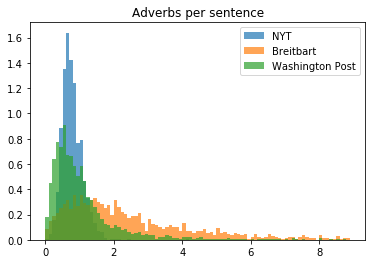

In [282]:
#adverb_count
#wapo.calc_sent_count()
#nyt.calc_sent_count()
#breit.calc_sent_count()
for i in [nyt, breit, wapo]:
    #print(breit.adverb_count)
    plt.hist([k['VB']/j for k,j in zip(nyt.verb_count, i.sent_count)], bins = [i/100. for i in list(range(0,900,10))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Adverbs per sentence")
plt.show()

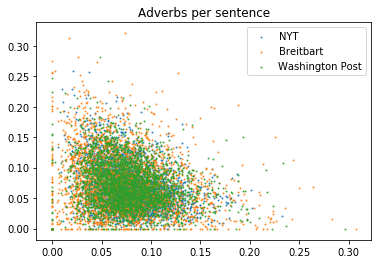

In [246]:
#sentiment score
for i in [nyt, breit, wapo]:
    #print(breit.adverb_count)
    #plt.hist([component[1]+component[3] for component in i.sentiment_vec], bins = [i/100. for i in list(range(0,200,1))], normed = True, alpha = 0.5)
    plt.scatter([component[1] for component in i.sentiment_vec], [component[3] for component in i.sentiment_vec], s = 1, alpha = 0.8)
plt.legend(labels = pub_list_labels)
plt.title("Sentiment score metrics (vader)")
plt.show()

# Finished features go into the plotting box below, in progress ones go above

In [194]:
pub_list = [nyt, breit, wapo]
pub_list_labels = ['NYT', 'Breitbart', 'Washington Post']

# Plot Data

/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


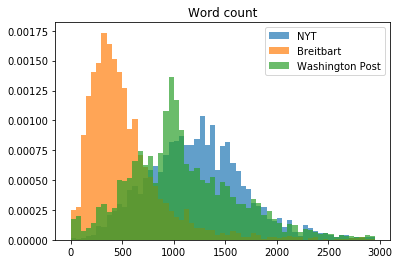

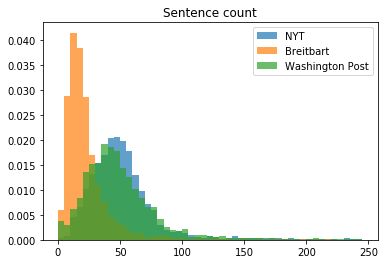

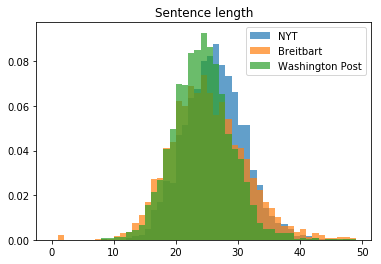

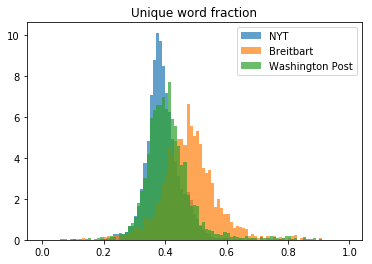

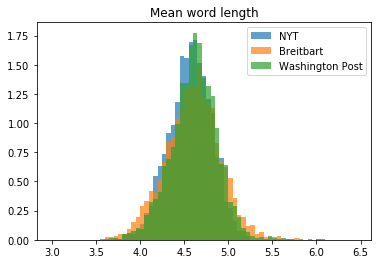

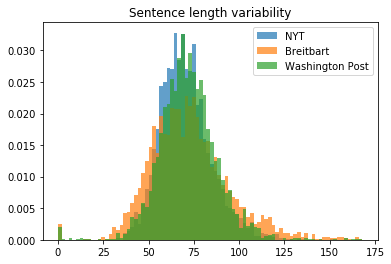

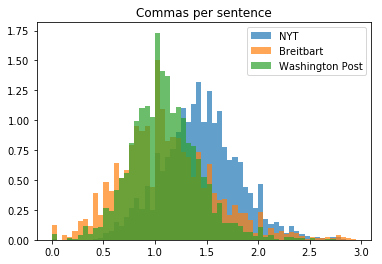

In [9]:
# Word Count

for i in pub_list:
    plt.hist(i.word_count, bins = list(range(0,3000,50)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Word count")
plt.show()

# Sentence Count

for i in pub_list:
    plt.hist(i.sent_count, bins = list(range(0,250,5)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Sentence count")
plt.show()
# Sentence Length

for i in pub_list:
    plt.hist(i.sent_len, bins = list(range(0,50,1)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Sentence length")
plt.show()
# Unique Word Count and Fraction

for i in pub_list:
    plt.hist(i.unique_word_frac, bins = [i/100. for i in list(range(0,100,1))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Unique word fraction")
plt.show()

# Mean word length

for i in pub_list:
    plt.hist(i.word_len, bins = [i/100. for i in list(range(300,650,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Mean word length")
plt.show()

# Sentence length distribution

for i in pub_list:
    plt.hist(i.sent_len_std, bins = list(range(0,170,2)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Sentence length variability")
plt.show()

# Commas per sentence

for i in pub_list:
    plt.hist(i.cps, bins = [i/100. for i in list(range(0,300,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Commas per sentence")
plt.show()

# compare given article to mean values of publications

### from sklearn import tree
#X = [[0, 0], [1, 1]]
#Y = [0, 1]
#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X, Y)

In [328]:
#join data
wc = []
sent_len = []
sent_len_std = []
unique_word_frac = []
word_len = []
cps = []
adverb_ps = []
sup_adv_ps = []
verb_ps = []
#feature names: word_count, sent_count, sent_len, unique_word_frac, word_len, sent_len_std, cps
for i in [nyt, breit, wapo]:
    wc += i.word_count
    sent_len += i.sent_len
    word_len += i.word_len
    sent_len_std += i.sent_len_std
    unique_word_frac += i.unique_word_frac
    cps += i.cps
    adverb_ps += [float(sum(dict_vals.values())/sl) for dict_vals, sl in zip(i.adverb_count, i.sent_count)]
    sup_adv_ps += [float(dict_vals['WRB']/sl) for dict_vals, sl in zip(i.adverb_count, i.sent_count)]
    verb_ps += [float(sum(dict_vals.values())/sl) for dict_vals, sl in zip(i.verb_count, i.sent_count)]
#print(nyt.adverb_count)
#print(total_adverb_ps[:10])
#wc = nyt_wc + breit_wc + wapo_wc
#sent_len = nyt_sent_len + breit_sent_len + wapo_sent_len
#sent_len_std = nyt_sent_len_std + breit_sent_len_std + wapo_sent_len_std
#unique_word_frac = nyt_unique_word_frac + breit_unique_word_frac + wapo_unique_word_frac
#word_len = nyt_word_len + breit_word_len + wapo_word_len
#cps = nyt_cps + breit_cps + wapo_cps
#print(len(wc), len(word_length))

In [329]:
#combine features
X = [[i, j, k, l, m, n, o] for i, j, k, l, m, n, o in zip(
    sent_len, sent_len_std, unique_word_frac, word_len, cps, sup_adv_ps, verb_ps)]
n_samples = len(X)
data_boundaries = [len(i.word_count) for i in [nyt, breit, wapo]]
print(data_boundaries)
cumulative_bounds = [0]
for ci, i in enumerate(data_boundaries):
    cumulative_bounds.append(i+cumulative_bounds[ci])
print(cumulative_bounds)
#cumulative_bounds = [0]
#cumulative_bounds = [cumulative_bounds[i-1] + i for i in data_boundaries]
print(len(X))

[3040, 2990, 3056]
[0, 3040, 6030, 9086]
9086


In [330]:
#labels
Y = [0 for i in range(len(nyt.word_count))] + [1 for i in range(len(breit.word_count))] + [2 for i in range(len(wapo.word_count))]
print(len(Y))

9086


In [331]:
#test train split
from sklearn.model_selection import train_test_split

indices = np.arange(n_samples)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.2)
print(idx_train)
print(idx_test)

[1546 4313 1850 ...  129 8643 7289]
[3839 3802 3039 ... 1022 3947 9084]


In [332]:
text_list = nyt_sent + breit_sent + wapo_sent
print(len(text_list))

9086


In [333]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'max_depth':range(3,20)}
#clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
#clf.fit(X=X_train, y=y_train)
#tree_model = clf.best_estimator_
#print (clf.best_score_, clf.best_params_) 


#clf = tree.DecisionTreeClassifier(max_depth = 5)
#clf = clf.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

In [334]:
y_pred = clf.predict(X_test)
#chance = [0 if random.random() > 0.5 else 1 for _ in range(len(y_pred))]

Normalized confusion matrix
[[0.68 0.13 0.19]
 [0.15 0.68 0.18]
 [0.26 0.25 0.49]]


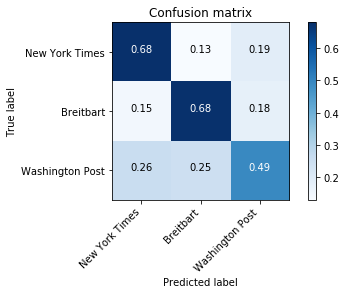

In [335]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['New York Times', 'Breitbart', 'Washington Post']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize = True)


Feature ranking:
1. feature 2 (0.210477)
2. feature 4 (0.199261)
3. feature 1 (0.139600)
4. feature 3 (0.113147)
5. feature 0 (0.112695)
6. feature 5 (0.112461)
7. feature 6 (0.112359)
[2 4 1 3 0 5 6]


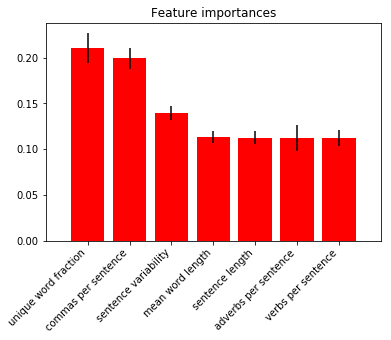

In [336]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(X[0])):#.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
feature_names = ['sentence length', 'sentence variability', 'unique word fraction', 
                 'mean word length', 'commas per sentence', 'adverbs per sentence', 'verbs per sentence']
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(X[0])), importances[indices],
       color="r", yerr=std[indices], align="center")
print(indices)
plt.xticks(range(len(X[0])), [feature_names[i] for i in indices], rotation = 45, ha = 'right')
plt.xlim([-1, len(X[0])])
plt.show()


In [84]:
conf_mat = np.zeros((3,3))
count = 0
for pred, true in zip(y_pred, y_test):
    if pred == 2 and true == 1:
            print(pred, true, count, 'mismatch')
            print(' '.join(text_list[idx_test[count]]))
            input()
    conf_mat[pred,true] += 1.
    count += 1
print(count)
#conf_mat[2,1] += 1000
#[y,x] format (first index (predicted) is on the vertical, second index (truth) is on the horizontal)
plt.imshow(conf_mat)
plt.colorbar()
print(conf_mat, np.sum(conf_mat))
print(Counter(y_test))

2 1 20 mismatch
the mainstream media are abuzz with claims that house republicans have voted to "gut" or "eviscerate" the office of congressional ethics (oce) or to strip it of its independence. [perpetual house minority leader nancy pelosi ( ) claimed republicans had "eliminated" the oversight body, and linked the move to   donald trump, claiming that the house republicans’ move represents a violation of trump’s campaign promise to "drain the swamp" in washington. the story qualifies as "fake news," and the fact that it is being repeated by so many outlets does not make the it any less fake. first of all, the change  —   voted on by republicans on monday as part of their larger rules package  —   has nothing to do with trump. the house sets its own rules, and it would actually be an encroachment on the separation of powers for trump to tell it to do otherwise. furthermore, republicans have been in control of the house since 2011 and have left the oce alone. what republicans actually d


2 1 46 mismatch
four israeli soldiers were murdered and at least 16 people were wounded, some seriously, when an arab resident of eastern jerusalem rammed his truck into pedestrians near jerusalem’s armon hanatziv promenade. [armon hanatziv, also known as east talpiot, is located in southeastern jerusalem, part of the eastern sections of jerusalem declared "occupied palestinian territory" by a united nations security council resolution last month. the promenade, a popular tourist site enjoyed for its spectacular views of israel’s capital, is located about half a mile from the plot of land upon which the u. s. has been building a consulate that could serve as a future embassy if the current embassy is moved from tel aviv to jerusalem. prime minister benjamin netanyahu told reporters at the scene of the attack: "we know the identity of the attacker. all signs point to the attacker being a supporter of the islamic state. " in sunday’s vehicular terrorist attack, fadi   identified as resi

KeyboardInterrupt: 

# Section for testing new article against mean features

In [ ]:
def compare_article(text_features):
    #pub_list = [nyt, breit, wapo]
    wc_mean = [np.mean(i.word_count) for i in pub_list]
    print(wc_mean)
    #wc_mean1 = [np.mean(nyt_wc), np.mean(breit_wc), np.mean(wapo_wc)]
    #print(wc_mean, wc_mean1)
    sent_len_mean = [np.mean(i.sent_len) for i in pub_list]#, np.mean(breit_sent_len), np.mean(wapo_sent_len)]
    sent_len_std_mean = [np.mean(i.sent_len_std) for i in pub_list]#, np.mean(breit_sent_len_std), np.mean(wapo_sent_len_std)]
    unique_word_frac_mean = [np.mean(i.unique_word_frac) for i in pub_list]#, np.mean(breit_unique_word_frac), np.mean(wapo_unique_word_frac)]
    word_len_mean = [np.mean(i.word_len) for i in pub_list]#, np.mean(breit_word_len), np.mean(wapo_word_len)]
    cps_mean = [np.mean(i.cps) for i in pub_list]#, np.mean(breit_cps), np.mean(wapo_cps)]
    features = ['sentence length', 'sentence length distribution', 'unique word fraction', 'word length', 'commas per sentence']
    mean_features = [[i, j, k, l, m] for i, j, k, l, m in zip(sent_len_mean, sent_len_std_mean, unique_word_frac_mean, word_len_mean, cps_mean)]
    print(mean_features)
    pickle.dump(mean_features, open('mean_features.p', 'wb'))
    return [[float(i/j) for i,j in zip(text_features, pub_features)] for pub_features in mean_features]

In [ ]:
#generate features for a single text (THIS NEEDS TO GO INTO THE CLASS)
def generate_features(text):
    sent_tok, word_tok, string_counts = prepare_text(text)
    sent_tok = sent_tok[0]
    word_tok = word_tok[0]
    string_counts = string_counts[0]
    
    punctuation_set = set(string.punctuation)
    word_count = len([word for word in word_tok if word not in punctuation_set])
    sent_count = len(sent_tok)
    sent_len = float(word_count / sent_count)
    sent_std = np.std([len(sent) for sent in sent_tok])

    unique_word_count = len(set([word for word in word_tok if word not in punctuation_set]))
    unique_word_frac = float(unique_word_count / word_count)
    mean_word_length = np.mean([len(word) for word in word_tok if word not in punctuation_set])

    cps = string_counts[',']/sent_count
    return [sent_len, sent_std, unique_word_frac, mean_word_length, cps]

In [119]:
#print(' '.join(nyt_sent[0]))
features = generate_features([' '.join(nyt_sent[10])])

print(features)
features_compare_to_mean = compare_article(features)
features = ['sentence length', 'sentence length distribution', 'unique word fraction', 'word length', 'commas per sentence']
plt.title('Features compared to average for {}'.format("New York Times"))
plt.bar(list(range(5)), features_compare_to_mean[2], color = 'r')
plt.bar(list(range(5)), [1 for _ in range(5)], color = 'black', alpha = 0.5)
#plt.ylim((0,1.2))
plt.xticks(range(5), features, rotation = 45, ha = 'right')
#plt.bar(list(range(5)), features_compare_to_mean[1], alpha = 0.5)

#plt.bar(list(range(5)), features_compare_to_mean[2], alpha = 0.5)

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'decision_tree_10.pkl') 

In [176]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.